In [ ]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# NLP và Sentiment Analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder


Thư viện đã được import thành công


In [2]:
# Load dữ liệu
print("Đang load dữ liệu...")
df = pd.read_csv('reviews.csv')

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Tổng số đánh giá: {len(df):,}")

# Kiểm tra cấu trúc dữ liệu
print("\nCác cột trong dataset:")
print(df.columns.tolist())

print("\nThông tin cơ bản:")
df.info()

print("\n5 dòng đầu tiên:")
df.head()


Đang load dữ liệu...
Kích thước dữ liệu: (568454, 10)
Tổng số đánh giá: 568,454

Các cột trong dataset:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Thông tin cơ bản:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# Phân tích dữ liệu cơ bản
print("Missing values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Xác định cột text chính
text_columns = [col for col in df.columns if 'text' in col.lower() or 'review' in col.lower() or 'comment' in col.lower()]
print(f"\nCột text được tìm thấy: {text_columns}")

# Xác định cột rating nếu có
rating_columns = [col for col in df.columns if 'rating' in col.lower() or 'score' in col.lower() or 'star' in col.lower()]
print(f"Cột rating được tìm thấy: {rating_columns}")

# Hiển thị thống kê rating nếu có
if rating_columns:
    rating_col = rating_columns[0]
    print(f"\nPhân phối rating ({rating_col}):")
    print(df[rating_col].value_counts().sort_index())


Missing values:
ProfileName    26
Summary        27
dtype: int64

Cột text được tìm thấy: ['Text']
Cột rating được tìm thấy: ['Score']

Phân phối rating (Score):
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


In [4]:
# Khởi tạo các công cụ
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
analyzer = SentimentIntensityAnalyzer()

def clean_text(text):
    """Làm sạch và chuẩn hóa text"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s!?.,]', '', text)  # Keep basic punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    
    return text

def preprocess_text(text):
    """Tiền xử lý text cho machine learning"""
    text = clean_text(text)
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

print("Đã khởi tạo các function tiền xử lý")


Đã khởi tạo các function tiền xử lý


In [5]:
# Xác định cột text chính và áp dụng tiền xử lý
# Tự động xác định cột text chính
if text_columns:
    main_text_col = text_columns[0]
    print(f"Sử dụng cột '{main_text_col}' làm text chính")
else:
    # Fallback: tìm cột có nhiều text nhất
    text_candidates = []
    for col in df.columns:
        if df[col].dtype == 'object':
            avg_length = df[col].astype(str).str.len().mean()
            if avg_length > 20:  # Cột có độ dài trung bình > 20 ký tự
                text_candidates.append((col, avg_length))
    
    if text_candidates:
        main_text_col = max(text_candidates, key=lambda x: x[1])[0]
        print(f"Tự động chọn cột '{main_text_col}' làm text chính")
    else:
        print("Không tìm thấy cột text phù hợp")
        main_text_col = df.columns[0]  # Fallback

# Tạo dataset sạch
df_clean = df.copy()
df_clean = df_clean.dropna(subset=[main_text_col])
df_clean = df_clean[df_clean[main_text_col].astype(str).str.strip() != '']

print(f"Số dòng sau khi làm sạch: {len(df_clean):,}")

# Áp dụng tiền xử lý
print("Đang tiền xử lý text...")
df_clean['text_cleaned'] = df_clean[main_text_col].apply(clean_text)
df_clean['text_processed'] = df_clean[main_text_col].apply(preprocess_text)
df_clean['text_length'] = df_clean['text_cleaned'].str.len()

print("Hoàn thành tiền xử lý")
print(f"Độ dài text trung bình: {df_clean['text_length'].mean():.1f} ký tự")


Sử dụng cột 'Text' làm text chính
Số dòng sau khi làm sạch: 568,454
Đang tiền xử lý text...
Hoàn thành tiền xử lý
Độ dài text trung bình: 421.6 ký tự


In [6]:
def analyze_sentiment_multidimensional(text):
    """Phân tích cảm xúc đa chiều sử dụng VADER và TextBlob"""
    
    # VADER Sentiment
    vader_scores = analyzer.polarity_scores(text)
    
    # TextBlob Sentiment
    blob = TextBlob(text)
    
    # Kết hợp và phân loại
    compound = vader_scores['compound']
    
    if compound >= 0.05:
        sentiment_label = 'Positive'
    elif compound <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    
    return {
        'vader_compound': compound,
        'vader_positive': vader_scores['pos'],
        'vader_negative': vader_scores['neg'],
        'vader_neutral': vader_scores['neu'],
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity,
        'sentiment_label': sentiment_label,
        'emotion_intensity': abs(compound)
    }

# Áp dụng phân tích cảm xúc
print("Đang phân tích cảm xúc...")
sentiment_results = df_clean['text_cleaned'].apply(analyze_sentiment_multidimensional)

# Chuyển đổi thành DataFrame
sentiment_df = pd.json_normalize(sentiment_results)
df_analysis = pd.concat([df_clean.reset_index(drop=True), sentiment_df], axis=1)

print("Hoàn thành phân tích cảm xúc")
print("\nPhân phối cảm xúc:")
print(df_analysis['sentiment_label'].value_counts())
print(f"\nĐiểm cảm xúc trung bình: {df_analysis['vader_compound'].mean():.3f}")


Đang phân tích cảm xúc...
Hoàn thành phân tích cảm xúc

Phân phối cảm xúc:
sentiment_label
Positive    499219
Negative     57222
Neutral      12013
Name: count, dtype: int64

Điểm cảm xúc trung bình: 0.654


In [7]:
def calculate_helpfulness_score(row):
    """Tính điểm hữu ích dựa trên nhiều yếu tố"""
    
    # Điểm cơ bản từ độ dài text (30%)
    length_score = min(1.0, row['text_length'] / 200) * 0.3
    
    # Điểm từ tính khách quan (25%) - ít chủ quan hơn thì hữu ích hơn
    objectivity_score = (1 - row['textblob_subjectivity']) * 0.25
    
    # Điểm từ cường độ cảm xúc (20%) - cảm xúc rõ ràng hơn
    emotion_score = row['emotion_intensity'] * 0.2
    
    # Điểm từ sự cân bằng VADER (15%)
    balance_score = (row['vader_positive'] + row['vader_negative']) * 0.15
    
    # Điểm bonus (10%)
    bonus_score = 0.1
    
    total_score = length_score + objectivity_score + emotion_score + balance_score + bonus_score
    return min(1.0, total_score)

# Tính điểm hữu ích
print("Đang tính điểm hữu ích...")
df_analysis['helpfulness_score'] = df_analysis.apply(calculate_helpfulness_score, axis=1)

# Phân loại mức độ hữu ích
def categorize_helpfulness(score):
    if score >= 0.8:
        return 'Rất hữu ích'
    elif score >= 0.6:
        return 'Hữu ích'
    elif score >= 0.4:
        return 'Trung bình'
    else:
        return 'Ít hữu ích'

df_analysis['helpfulness_category'] = df_analysis['helpfulness_score'].apply(categorize_helpfulness)

print("Hoàn thành tính điểm hữu ích")
print("\nPhân phối mức độ hữu ích:")
print(df_analysis['helpfulness_category'].value_counts())
print(f"\nĐiểm hữu ích trung bình: {df_analysis['helpfulness_score'].mean():.3f}")


Đang tính điểm hữu ích...
Hoàn thành tính điểm hữu ích

Phân phối mức độ hữu ích:
helpfulness_category
Hữu ích        456412
Trung bình     106335
Ít hữu ích       3902
Rất hữu ích      1805
Name: count, dtype: int64

Điểm hữu ích trung bình: 0.671


In [8]:
# Kiểm tra và xây dựng mô hình dự đoán
if rating_columns and len(df_analysis) > 100:
    rating_col = rating_columns[0]
    
    # Chuẩn bị dữ liệu cho mô hình
    df_model = df_analysis.dropna(subset=[rating_col]).copy()
    
    if len(df_model) > 50:
        print(f"Xây dựng mô hình dự đoán cho cột '{rating_col}'...")
        
        # Tạo features
        tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
        X_text = tfidf.fit_transform(df_model['text_processed'])
        
        # Features từ sentiment analysis
        sentiment_features = df_model[[
            'vader_compound', 'vader_positive', 'vader_negative', 'vader_neutral',
            'textblob_polarity', 'textblob_subjectivity', 'emotion_intensity',
            'text_length', 'helpfulness_score'
        ]].values
        
        # Kết hợp features
        from scipy.sparse import hstack
        X = hstack([X_text, sentiment_features])
        y = df_model[rating_col].values
        
        # Chia train/test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Train mô hình
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        
        model_results = {}
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            model_results[name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': y_pred
            }
            
            print(f"Accuracy: {accuracy:.4f}")
        
        # Chọn mô hình tốt nhất
        best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
        best_model = model_results[best_model_name]['model']
        
        print(f"\nMô hình tốt nhất: {best_model_name}")
        print(f"Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
        
        # Dự đoán cho toàn bộ dataset
        X_all_text = tfidf.transform(df_analysis['text_processed'])
        X_all_sentiment = df_analysis[[
            'vader_compound', 'vader_positive', 'vader_negative', 'vader_neutral',
            'textblob_polarity', 'textblob_subjectivity', 'emotion_intensity',
            'text_length', 'helpfulness_score'
        ]].values
        X_all = hstack([X_all_text, X_all_sentiment])
        
        df_analysis['predicted_rating'] = best_model.predict(X_all)
        
        print("Đã thêm cột predicted_rating vào dataset")
    else:
        print("Không đủ dữ liệu để xây dựng mô hình dự đoán")
else:
    print("Không tìm thấy cột rating hoặc không đủ dữ liệu để xây dựng mô hình")


Xây dựng mô hình dự đoán cho cột 'Score'...

Training Random Forest...
Accuracy: 0.8097

Training Logistic Regression...
Accuracy: 0.6823

Mô hình tốt nhất: Random Forest
Accuracy: 0.8097
Đã thêm cột predicted_rating vào dataset


In [9]:
# Phân tích từ khóa và chủ đề
from collections import Counter
import re

def extract_keywords(text, sentiment):
    """Trích xuất từ khóa quan trọng theo sentiment"""
    words = re.findall(r'\b\w{3,}\b', text.lower())
    # Loại bỏ stopwords
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

# Trích xuất từ khóa theo sentiment
positive_keywords = []
negative_keywords = []
neutral_keywords = []

for idx, row in df_analysis.iterrows():
    keywords = extract_keywords(row['text_cleaned'], row['sentiment_label'])
    
    if row['sentiment_label'] == 'Positive':
        positive_keywords.extend(keywords)
    elif row['sentiment_label'] == 'Negative':
        negative_keywords.extend(keywords)
    else:
        neutral_keywords.extend(keywords)

# Top keywords cho mỗi sentiment
print("Top 10 từ khóa tích cực:")
top_positive = Counter(positive_keywords).most_common(10)
for word, count in top_positive:
    print(f"  {word}: {count}")

print("\nTop 10 từ khóa tiêu cực:")
top_negative = Counter(negative_keywords).most_common(10)
for word, count in top_negative:
    print(f"  {word}: {count}")

# Lưu vào dataframe để phân tích
keyword_analysis = {
    'positive_keywords': dict(top_positive),
    'negative_keywords': dict(top_negative),
    'neutral_keywords': dict(Counter(neutral_keywords).most_common(10))
}


Top 10 từ khóa tích cực:
  like: 231263
  good: 186506
  great: 161168
  one: 154114
  taste: 150884
  coffee: 148855
  flavor: 133239
  product: 128386
  tea: 124583
  love: 123390

Top 10 từ khóa tiêu cực:
  like: 19762
  product: 18588
  one: 17433
  taste: 17074
  would: 13725
  coffee: 13217
  food: 12818
  good: 11337
  flavor: 11237
  dont: 10748


In [10]:
# Phân tích so sánh theo các khía cạnh khác nhau

# 1. So sánh theo độ dài review
df_analysis['length_category'] = pd.cut(df_analysis['text_length'], 
                                       bins=[0, 50, 150, 500, float('inf')], 
                                       labels=['Rất ngắn', 'Ngắn', 'Trung bình', 'Dài'])

print("Cảm xúc theo độ dài review:")
length_sentiment = df_analysis.groupby('length_category')['vader_compound'].agg(['mean', 'count'])
print(length_sentiment)

# 2. So sánh theo mức độ hữu ích
print("\nCảm xúc theo mức độ hữu ích:")
helpful_sentiment = df_analysis.groupby('helpfulness_category')['vader_compound'].agg(['mean', 'count'])
print(helpful_sentiment)

# 3. Phân tích correlation
print("\nCorrelation matrix:")
correlation_cols = ['vader_compound', 'textblob_polarity', 'emotion_intensity', 
                   'helpfulness_score', 'text_length']
if 'predicted_rating' in df_analysis.columns:
    correlation_cols.append('predicted_rating')

correlation_matrix = df_analysis[correlation_cols].corr()
print(correlation_matrix.round(3))

# 4. Thống kê tổng hợp
print("\nThống kê tổng hợp:")
summary_stats = {
    'Tổng số reviews': len(df_analysis),
    'Sentiment tích cực': f"{(df_analysis['sentiment_label'] == 'Positive').mean():.1%}",
    'Sentiment tiêu cực': f"{(df_analysis['sentiment_label'] == 'Negative').mean():.1%}",
    'Sentiment trung tính': f"{(df_analysis['sentiment_label'] == 'Neutral').mean():.1%}",
    'Điểm sentiment trung bình': f"{df_analysis['vader_compound'].mean():.3f}",
    'Điểm hữu ích trung bình': f"{df_analysis['helpfulness_score'].mean():.3f}",
    'Reviews rất hữu ích': f"{(df_analysis['helpfulness_category'] == 'Rất hữu ích').mean():.1%}"
}

for key, value in summary_stats.items():
    print(f"  {key}: {value}")


Cảm xúc theo độ dài review:
                     mean   count
length_category                  
Rất ngắn         0.389936     121
Ngắn             0.578155  101367
Trung bình       0.638382  320197
Dài              0.740665  146769

Cảm xúc theo mức độ hữu ích:
                          mean   count
helpfulness_category                  
Hữu ích               0.729853  456412
Rất hữu ích           0.776672    1805
Trung bình            0.347048  106335
Ít hữu ích            0.089324    3902

Correlation matrix:
                   vader_compound  textblob_polarity  emotion_intensity  \
vader_compound              1.000              0.475              0.652   
textblob_polarity           0.475              1.000              0.326   
emotion_intensity           0.652              0.326              1.000   
helpfulness_score           0.443             -0.006              0.724   
text_length                 0.122             -0.201              0.243   
predicted_rating            0.526

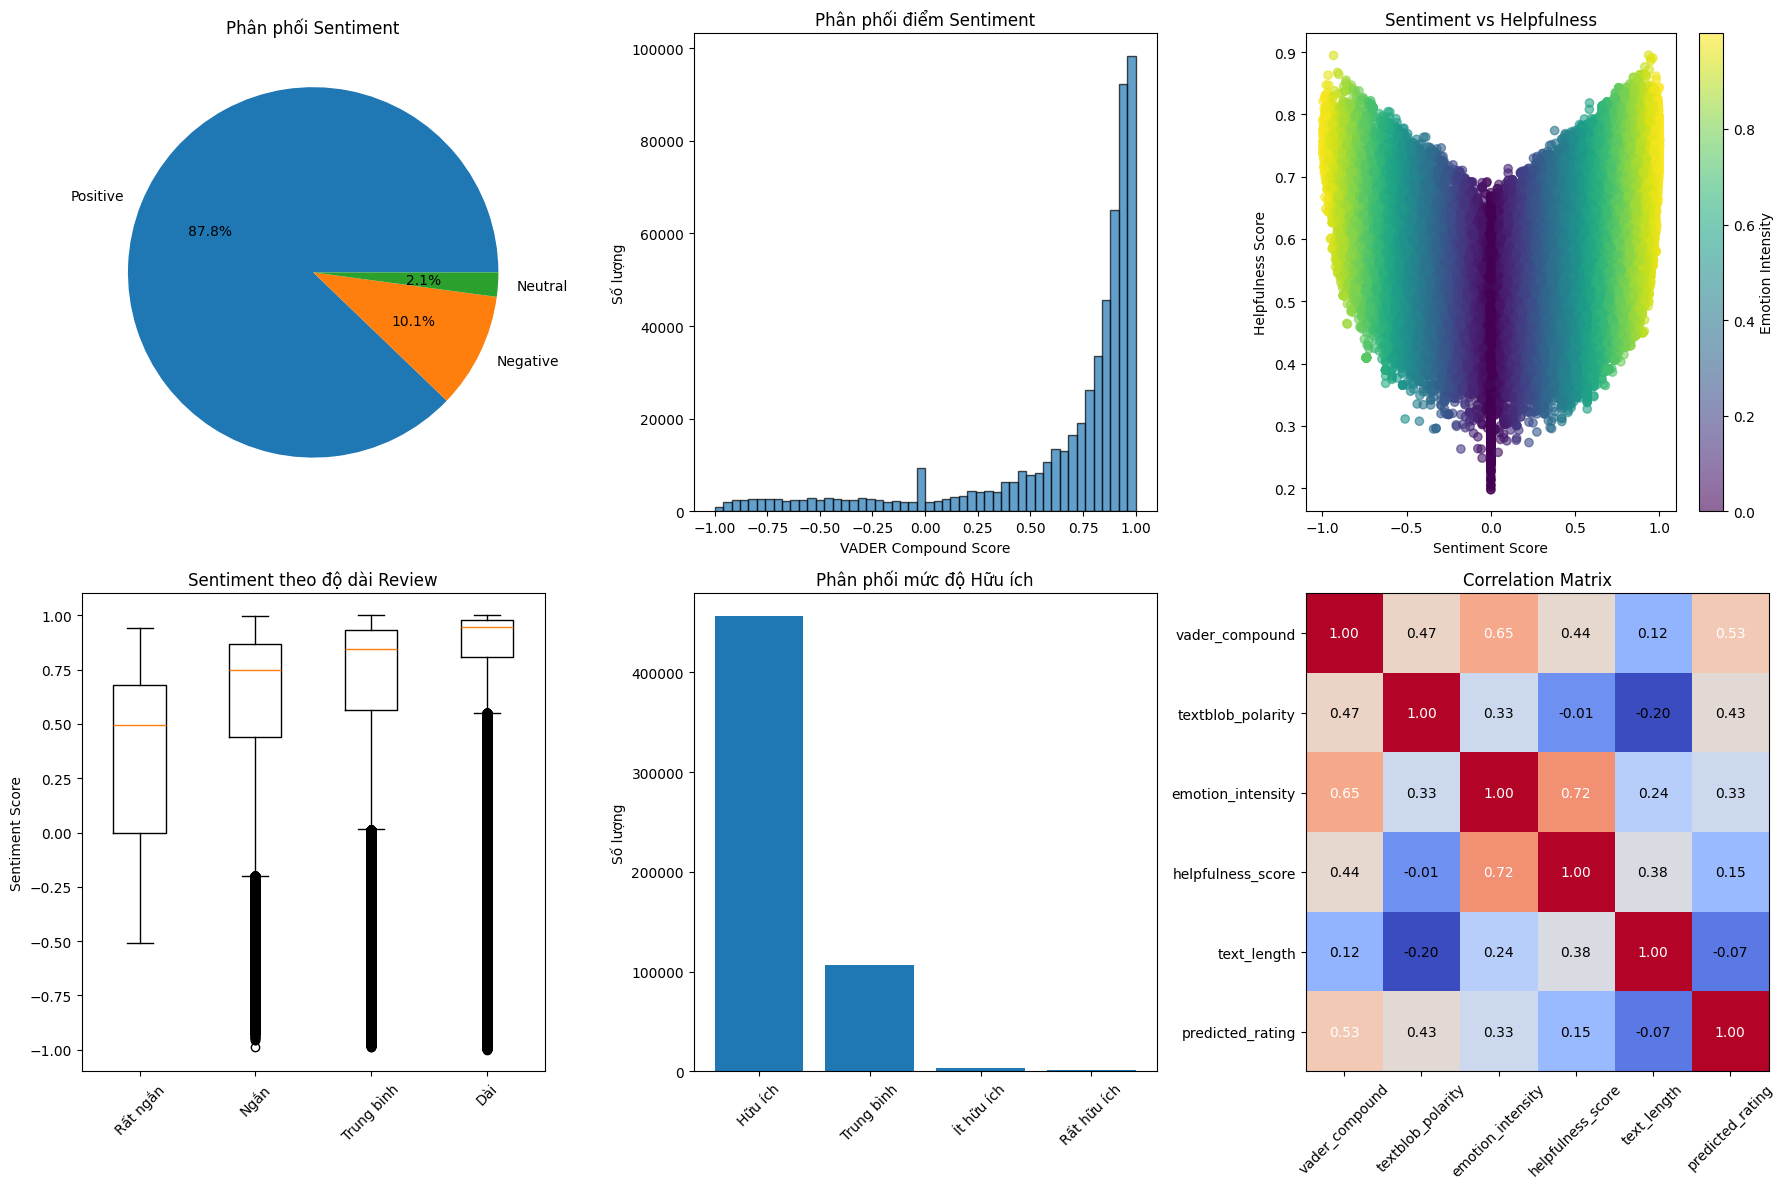

Dashboard đã được tạo và lưu thành 'sentiment_analysis_dashboard.png'


In [11]:
# Tạo visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Phân phối sentiment
sentiment_counts = df_analysis['sentiment_label'].value_counts()
axes[0,0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0,0].set_title('Phân phối Sentiment')

# 2. Histogram điểm sentiment
axes[0,1].hist(df_analysis['vader_compound'], bins=50, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Phân phối điểm Sentiment')
axes[0,1].set_xlabel('VADER Compound Score')
axes[0,1].set_ylabel('Số lượng')

# 3. Scatter plot: Sentiment vs Helpfulness
scatter = axes[0,2].scatter(df_analysis['vader_compound'], df_analysis['helpfulness_score'], 
                           c=df_analysis['emotion_intensity'], alpha=0.6, cmap='viridis')
axes[0,2].set_title('Sentiment vs Helpfulness')
axes[0,2].set_xlabel('Sentiment Score')
axes[0,2].set_ylabel('Helpfulness Score')
plt.colorbar(scatter, ax=axes[0,2], label='Emotion Intensity')

# 4. Boxplot: Sentiment by Length Category
length_categories = df_analysis['length_category'].cat.categories
sentiment_by_length = [df_analysis[df_analysis['length_category'] == cat]['vader_compound'].values 
                      for cat in length_categories]
axes[1,0].boxplot(sentiment_by_length, labels=length_categories)
axes[1,0].set_title('Sentiment theo độ dài Review')
axes[1,0].set_ylabel('Sentiment Score')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Bar chart: Helpfulness categories
helpful_counts = df_analysis['helpfulness_category'].value_counts()
axes[1,1].bar(helpful_counts.index, helpful_counts.values)
axes[1,1].set_title('Phân phối mức độ Hữu ích')
axes[1,1].set_ylabel('Số lượng')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Heatmap correlation
correlation_data = df_analysis[correlation_cols].corr()
im = axes[1,2].imshow(correlation_data, cmap='coolwarm', aspect='auto')
axes[1,2].set_xticks(range(len(correlation_cols)))
axes[1,2].set_yticks(range(len(correlation_cols)))
axes[1,2].set_xticklabels(correlation_cols, rotation=45)
axes[1,2].set_yticklabels(correlation_cols)
axes[1,2].set_title('Correlation Matrix')

# Thêm số vào heatmap
for i in range(len(correlation_cols)):
    for j in range(len(correlation_cols)):
        axes[1,2].text(j, i, f'{correlation_data.iloc[i, j]:.2f}', 
                      ha='center', va='center', color='white' if abs(correlation_data.iloc[i, j]) > 0.5 else 'black')

plt.tight_layout()
plt.savefig('sentiment_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("Dashboard đã được tạo và lưu thành 'sentiment_analysis_dashboard.png'")


In [12]:
# Tạo báo cáo kinh doanh chi tiết
print("=" * 80)
print("BÁO CÁO PHÂN TÍCH CẢM XÚC KHÁCH HÀNG")
print("=" * 80)

# 1. Tổng quan
print("\n1. TỔNG QUAN")
print("-" * 40)
total_reviews = len(df_analysis)
avg_sentiment = df_analysis['vader_compound'].mean()
avg_helpfulness = df_analysis['helpfulness_score'].mean()

print(f"Tổng số đánh giá: {total_reviews:,}")
print(f"Điểm cảm xúc trung bình: {avg_sentiment:.3f} (-1 đến +1)")
print(f"Điểm hữu ích trung bình: {avg_helpfulness:.3f} (0 đến 1)")
print(f"Độ dài review trung bình: {df_analysis['text_length'].mean():.0f} ký tự")

# 2. Phân tích cảm xúc
print("\n2. PHÂN TÍCH CẢM XÚC")
print("-" * 40)
sentiment_distribution = df_analysis['sentiment_label'].value_counts(normalize=True)
for sentiment, percentage in sentiment_distribution.items():
    print(f"{sentiment}: {percentage:.1%}")

# 3. Chất lượng đánh giá
print("\n3. CHẤT LƯỢNG ĐÁNH GIÁ")
print("-" * 40)
helpfulness_distribution = df_analysis['helpfulness_category'].value_counts(normalize=True)
for category, percentage in helpfulness_distribution.items():
    print(f"{category}: {percentage:.1%}")

# 4. Insights kinh doanh
print("\n4. INSIGHTS KINH DOANH")
print("-" * 40)

# Phân tích theo độ dài
length_analysis = df_analysis.groupby('length_category')['vader_compound'].mean()
print("Cảm xúc theo độ dài review:")
for category, sentiment in length_analysis.items():
    print(f"  {category}: {sentiment:.3f}")

# Top từ khóa
print("\nTừ khóa quan trọng:")
print("  Tích cực:", ", ".join([word for word, _ in top_positive[:5]]))
print("  Tiêu cực:", ", ".join([word for word, _ in top_negative[:5]]))

# 5. Khuyến nghị
print("\n5. KHUYẾN NGHỊ")
print("-" * 40)

recommendations = []

if sentiment_distribution['Negative'] > 0.2:
    recommendations.append("Cần cải thiện sản phẩm/dịch vụ - tỷ lệ đánh giá tiêu cực cao")

if helpfulness_distribution['Ít hữu ích'] > 0.3:
    recommendations.append("Khuyến khích khách hàng viết đánh giá chi tiết hơn")

if avg_sentiment < 0.1:
    recommendations.append("Cần có chiến lược cải thiện trải nghiệm khách hàng")

if length_analysis['Dài'] > length_analysis['Ngắn']:
    recommendations.append("Đánh giá dài có cảm xúc tích cực hơn - khuyến khích feedback chi tiết")

if not recommendations:
    recommendations.append("Tình hình tốt - duy trì chất lượng hiện tại")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "=" * 80)


BÁO CÁO PHÂN TÍCH CẢM XÚC KHÁCH HÀNG

1. TỔNG QUAN
----------------------------------------
Tổng số đánh giá: 568,454
Điểm cảm xúc trung bình: 0.654 (-1 đến +1)
Điểm hữu ích trung bình: 0.671 (0 đến 1)
Độ dài review trung bình: 422 ký tự

2. PHÂN TÍCH CẢM XÚC
----------------------------------------
Positive: 87.8%
Negative: 10.1%
Neutral: 2.1%

3. CHẤT LƯỢNG ĐÁNH GIÁ
----------------------------------------
Hữu ích: 80.3%
Trung bình: 18.7%
Ít hữu ích: 0.7%
Rất hữu ích: 0.3%

4. INSIGHTS KINH DOANH
----------------------------------------
Cảm xúc theo độ dài review:
  Rất ngắn: 0.390
  Ngắn: 0.578
  Trung bình: 0.638
  Dài: 0.741

Từ khóa quan trọng:
  Tích cực: like, good, great, one, taste
  Tiêu cực: like, product, one, taste, would

5. KHUYẾN NGHỊ
----------------------------------------
1. Đánh giá dài có cảm xúc tích cực hơn - khuyến khích feedback chi tiết



In [13]:
# Chuẩn bị và xuất kết quả
import json
from datetime import datetime

# 1. Xuất bảng thông tin chi tiết
output_columns = [
    main_text_col, 'text_cleaned', 'text_length',
    'sentiment_label', 'vader_compound', 'textblob_polarity', 'textblob_subjectivity',
    'emotion_intensity', 'helpfulness_score', 'helpfulness_category',
    'length_category'
]

# Thêm predicted_rating nếu có
if 'predicted_rating' in df_analysis.columns:
    output_columns.append('predicted_rating')

# Chỉ giữ các cột tồn tại
available_columns = [col for col in output_columns if col in df_analysis.columns]

df_results = df_analysis[available_columns].copy()
df_results.to_csv('sentiment_analysis_results.csv', index=False, encoding='utf-8')
print(f"Đã xuất {len(df_results)} dòng kết quả ra 'sentiment_analysis_results.csv'")

# 2. Xuất báo cáo tóm tắt JSON
summary_report = {
    'metadata': {
        'analysis_date': datetime.now().isoformat(),
        'total_reviews': int(total_reviews),
        'main_text_column': main_text_col
    },
    'sentiment_analysis': {
        'distribution': {k: f"{v:.1%}" for k, v in sentiment_distribution.items()},
        'average_score': float(avg_sentiment),
        'emotion_intensity_avg': float(df_analysis['emotion_intensity'].mean())
    },
    'helpfulness_analysis': {
        'distribution': {k: f"{v:.1%}" for k, v in helpfulness_distribution.items()},
        'average_score': float(avg_helpfulness)
    },
    'keyword_analysis': keyword_analysis,
    'recommendations': recommendations,
    'statistics': {
        'avg_text_length': float(df_analysis['text_length'].mean()),
        'correlation_sentiment_helpfulness': float(df_analysis[['vader_compound', 'helpfulness_score']].corr().iloc[0,1])
    }
}

with open('sentiment_analysis_report.json', 'w', encoding='utf-8') as f:
    json.dump(summary_report, f, indent=2, ensure_ascii=False)

print("Đã xuất báo cáo tóm tắt ra 'sentiment_analysis_report.json'")

# 3. Hiển thị tóm tắt cuối
print("\n" + "=" * 60)
print("HOÀN THÀNH PHÂN TÍCH CẢM XÚC")
print("=" * 60)
print(f"Đã phân tích {total_reviews:,} đánh giá")
print(f"Sentiment trung bình: {avg_sentiment:.3f}")
print(f"Tỷ lệ tích cực: {sentiment_distribution.get('Positive', 0):.1%}")
print(f"Reviews hữu ích: {helpfulness_distribution.get('Hữu ích', 0) + helpfulness_distribution.get('Rất hữu ích', 0):.1%}")

print("\nFile đã tạo:")
print("- sentiment_analysis_results.csv (kết quả chi tiết)")
print("- sentiment_analysis_report.json (báo cáo tóm tắt)")
print("- sentiment_analysis_dashboard.png (biểu đồ)")
print("\nHệ thống phân tích cảm xúc hoàn thành!")


Đã xuất 568454 dòng kết quả ra 'sentiment_analysis_results.csv'
Đã xuất báo cáo tóm tắt ra 'sentiment_analysis_report.json'

HOÀN THÀNH PHÂN TÍCH CẢM XÚC
Đã phân tích 568,454 đánh giá
Sentiment trung bình: 0.654
Tỷ lệ tích cực: 87.8%
Reviews hữu ích: 80.6%

File đã tạo:
- sentiment_analysis_results.csv (kết quả chi tiết)
- sentiment_analysis_report.json (báo cáo tóm tắt)
- sentiment_analysis_dashboard.png (biểu đồ)

Hệ thống phân tích cảm xúc hoàn thành!


In [ ]:
# Lưu model
import joblib
import os

# Tạo thư mục lưu model
os.makedirs('saved_models', exist_ok=True)

# Lưu TfidfVectorizer và mô hình tốt nhất
if 'tfidf' in locals() and 'best_model' in locals():
    joblib.dump(tfidf, 'saved_models/tfidf_vectorizer.pkl')
    joblib.dump(best_model, 'saved_models/best_model.pkl')
    
    # Lưu pipeline hoàn chỉnh
    pipeline = {
        'tfidf': tfidf,
        'model': best_model,
        'model_name': best_model_name,
        'accuracy': model_results[best_model_name]['accuracy']
    }
    joblib.dump(pipeline, 'saved_models/complete_pipeline.pkl')
    
    print(f"đã lưu model {best_model_name} với accuracy: {model_results[best_model_name]['accuracy']:.4f}")
else:
    print(" Chưa có model để lưu.")


✓ Đã lưu model Random Forest với accuracy: 0.8097
✓ Files đã lưu:
  - saved_models/tfidf_vectorizer.pkl
  - saved_models/best_model.pkl
  - saved_models/complete_pipeline.pkl


In [ ]:
# Load dữ liệu
print("Đang load dữ liệu...")
df = pd.read_csv('reviews.csv')

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Tổng số đánh giá: {len(df):,}")

# Kiểm tra cấu trúc dữ liệu
print("\nCác cột trong dataset:")
print(df.columns.tolist())

print("\nThông tin cơ bản:")
df.info()

print("\n5 dòng đầu tiên:")
df.head()


Đang load dữ liệu...
Kích thước dữ liệu: (568454, 10)
Tổng số đánh giá: 568,454

Các cột trong dataset:
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

Thông tin cơ bản:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
